In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

/var/folders/c3/5nt8gdz151v2dnbzbjm0mfs40000gn/T/ipykernel_12022/43875479.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [103]:
train_dir = "input/ucf-crime-dataset/Train"
test_dir = "input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 3
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"NormalVideos",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
CLASS_WEIGHT = {"Abuse" : 2,
                "Arrest" : 2,
                "Arson" : 2,
                "Assault" : 2,
                "Burglary" : 2,
                "Explosion" : 2,
                "Fighting" : 2,
                "NormalVideos": 0.1,
                "RoadAccidents": 2,
                "Robbery": 2,
                "Shooting": 2,
                "Shoplifting": 2,
                "Stealing": 2,
                "Vandalism": 2}

In [104]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )


In [105]:
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )
# 클래스 인덱스를 클래스 이름 기반으로 얻습니다
class_indices = {cls: i for i, cls in enumerate(train_generator.class_indices)}

# 클래스 인덱스를 사용하여 CLASS_WEIGHT를 업데이트합니다
CLASS_WEIGHT = {class_indices[cls]: weight for cls, weight in CLASS_WEIGHT.items()}


Found 1266345 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


In [106]:
print(CLASS_WEIGHT)

{0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 0.1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2}


In [107]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x




def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 256)               262400    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1024)              263168    
                                                           

In [108]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS,class_weight=CLASS_WEIGHT)

Epoch 1/3
19787/19787 [==============================] - 8966s 453ms/step - loss: 1.6021 - auc_6: 0.7009 - val_loss: 2.2286 - val_auc_6: 0.7769
Epoch 2/3
19787/19787 [==============================] - 9753s 493ms/step - loss: 1.4592 - auc_6: 0.8273 - val_loss: 2.2084 - val_auc_6: 0.7822
Epoch 3/3
19787/19787 [==============================] - 8980s 454ms/step - loss: 1.3889 - auc_6: 0.8656 - val_loss: 2.2176 - val_auc_6: 0.7802


1740/1740 [==============================] - 191s 110ms/step
ROC AUC score: 0.7804219188788853


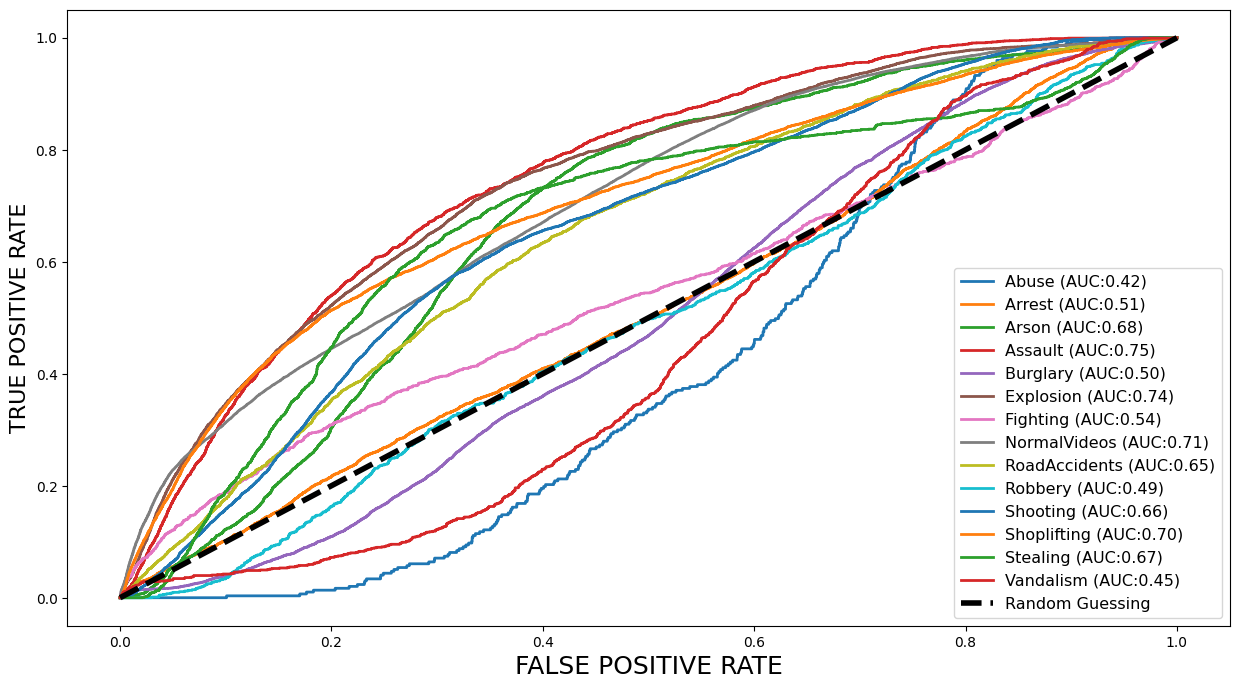

In [109]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [17]:
print(history)

In [72]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 경로 설정
image_path = "arson-exam.png"

# 이미지 불러오기 및 전처리
img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # 모델이 학습할 때 사용한 전처리에 맞게 스케일 조정

# 모델에 입력하여 예측 수행
predictions = model.predict(img_array)

# 최대 확률을 가진 클래스의 인덱스
predicted_class_index = np.argmax(predictions)

# 예측된 클래스 라벨
predicted_class_label = CLASS_LABELS[predicted_class_index]

# 예측 결과 및 클래스 출력
print("Predicted Probabilities:")
print(predictions)
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 1s 544ms/step
Predicted Probabilities:
[[6.4807035e-11 1.0753975e-11 5.3801634e-09 5.4316035e-13 5.4530250e-03
  2.9850442e-10 2.4689155e-12 9.8929954e-01 7.1154691e-09 5.2474802e-03
  4.8873947e-12 1.1417277e-08 5.2450373e-09 2.4492221e-11]]
Predicted Class: NormalVideos


In [94]:
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

# 웹캠 열기
cap = cv2.VideoCapture(0)

while True:
    # 웹캠에서 프레임 읽기
    ret, frame = cap.read()

    # 프레임 크기 조정
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))

    # 프레임 전처리
    img_array = image.img_to_array(frame)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 모델에 입력하여 예측 수행
    predictions = model.predict(img_array)

    # 최대 확률을 가진 클래스의 인덱스
    predicted_class_index = np.argmax(predictions)

    # 예측된 클래스 라벨
    predicted_class_label = CLASS_LABELS[predicted_class_index]

    # 예측 결과 및 클래스 출력
    cv2.putText(frame, f"Predicted Class: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("WebCam", frame)

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 웹캠 종료
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


In [25]:
pip install opencv-python --upgrade

  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (35.4 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.74
    Uninstalling opencv-python-4.8.0.74:
      Successfully uninstalled opencv-python-4.8.0.74
Note: you may need to restart the kernel to use updated packages.


In [110]:
# 모델 저장
model.save("3epoch_class_weight_0.1_model.h5")

# 저장된 모델 로드
loaded_model = tf.keras.models.load_model("3epoch_class_weight_0.1_model.h5")

# 모델 구조 출력
loaded_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 256)               262400    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1024)              263168    
                                                           

In [111]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 경로 설정
image_path = "arson-exam-2.jpeg"

# 이미지 불러오기 및 전처리
img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # 모델이 학습할 때 사용한 전처리에 맞게 스케일 조정

# 모델에 입력하여 예측 수행
predictions = loaded_model.predict(img_array)

# 최대 확률을 가진 클래스의 인덱스
predicted_class_index = np.argmax(predictions)

# 예측된 클래스 라벨
predicted_class_label = CLASS_LABELS[predicted_class_index]

# 예측 결과 및 클래스 출력
print("Predicted Probabilities:")
print(predictions)
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 1s 536ms/step
Predicted Probabilities:
[[4.05801838e-17 7.77248550e-16 3.31381629e-16 6.62487357e-22
  3.05362896e-12 3.76161349e-23 4.86864475e-14 1.00000000e+00
  1.00030044e-13 1.66610889e-14 4.70568021e-31 1.02538924e-11
  2.90994822e-13 2.80987080e-22]]
Predicted Class: NormalVideos


In [9]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
import time
import yaml

IMG_HEIGHT = 64
IMG_WIDTH = 64
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"NormalVideos",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

# 불러올 동영상 파일 경로
video_path = 'explosion_exam.mp4'

# 학습된 모델 파일 경로
model_path = '1epoch_class_weight_0.1_model.h5'

# YAML file path to save the output information
output_yaml_path = 'output_info.yaml'

# 동영상 읽기
cap = cv2.VideoCapture(video_path)

# 모델 불러오기
model = load_model(model_path)

current_class = None
class_start_time = None

class_info_list = []


# Frame counter
frame_counter = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_counter += 1

    # Process every frame
    if frame_counter % 10 == 0:
        # 프레임 전처리
        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
        img_array = image.img_to_array(frame)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # 모델이 학습할 때 사용한 전처리에 맞게 스케일 조정

        # 모델에 입력하여 예측 수행
        predictions = model.predict(img_array)

        # 최대 확률을 가진 클래스의 인덱스
        predicted_class_index = np.argmax(predictions)

        # 예측된 클래스 라벨
        predicted_class_label = CLASS_LABELS[predicted_class_index]

        # 예측 결과 및 클래스 출력
        # print("Predicted Probabilities:")
        # print(predictions)
        print(f"Predicted Class: {predicted_class_label}")
        

        if predicted_class_label != 'NormalVideos':
            
            if current_class != predicted_class_label:
                current_class = predicted_class_label
                class_start_time = time.strftime('%Y-%m-%d %H:%M:%S')
                print(f"{current_class} Start Time: {class_start_time}")

            cv2.imshow('Video', frame)

        else: 
            if current_class is not None:
                class_end_time = time.strftime('%Y-%m-%d %H:%M:%S')
                print(f"{current_class} End Time: {class_end_time}")

                
                class_info_list.append({'class': current_class, 'start_time': class_start_time, 'end_time': class_end_time})

                
                current_class = None
                class_start_time = None
        
        cv2.imshow('Video', frame)

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

with open(output_yaml_path, 'w') as yaml_file:
    yaml.dump(class_info_list, yaml_file)

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 505ms/step
Predicted Class: Burglary
Burglary Start Time: 2024-02-12 21:15:15
1/1 [==============================] - 0s 20ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 22ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 21ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 21ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 23ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 21ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 22ms/step
Predicted Class: Burglary
1/1 [==============================] - 0s 22ms/step
Predicted Class: NormalVideos
Burglary End Time: 2024-02-12 21:15:16
1/1 [==============================] - 0s 21ms/step
Predicted Class: Robbery
Robbery Start Time: 2024-02-12 21:15:17
1/1 [==============================] - 0s 22ms/step
Predicted Class: Burglary
Burglary Start Tim

In [81]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
from pytube import YouTube

# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=gOIaN_Jth4s'

# 학습된 모델 파일 경로
model_path = '1epoch_class_weight_0.1_model.h5'

# YouTube 영상 다운로드
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4').first()
video_stream.download('temp_video.mp4')

# 동영상 읽기
cap = cv2.VideoCapture('temp_video.mp4')

# 모델 불러오기
model = load_model(model_path)

# Frame counter
frame_counter = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_counter += 1

    # Process every 10th frame
    if frame_counter % 10 == 0:
        # 프레임 전처리
        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
        img_array = image.img_to_array(frame)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # 모델이 학습할 때 사용한 전처리에 맞게 스케일 조정

        # 모델에 입력하여 예측 수행
        predictions = model.predict(img_array)

        # 최대 확률을 가진 클래스의 인덱스
        predicted_class_index = np.argmax(predictions)

        # 예측된 클래스 라벨
        predicted_class_label = CLASS_LABELS[predicted_class_index]

        # 예측 결과 및 클래스 출력
        # print("Predicted Probabilities:")
        # print(predictions)
        print(f"Predicted Class: {predicted_class_label}")

        # 동영상 화면에 표시
        cv2.imshow('Video', frame)

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


OpenCV: Couldn't read video stream from file "temp_video.mp4"


In [96]:
# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=gRzSKcRtsLA'

# 학습된 모델 파일 경로
model_path = '1epoch_class_weight_0.1_model.h5'

# YouTube 영상 다운로드
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4').first()
video_stream.download('temp_video1.mp4')


'/Users/eonseon/temp_video1.mp4/CCTV captures moment of deadly house explosion in US.mp4'